In [1]:
from src.api.flipside_crypto import FlipsideCrypto
from src.misc.data import format_dtypes
import src.measures as measures

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
# see explore_slippage.ipynb for step-by-step explainations
# function for data formatting and calculation 

def format_swaps_df(df):
    return_columns = [
            "block_timestamp", "block_number", "tx_hash", 
            "amount0In", "amount0Out", "reserve0_before", "reserve0_after",
            "amount1In", "amount1Out", "reserve1_before", "reserve1_after", 
            ]

    # split events into Syncs and Swaps
    syncs_df = df.loc[df["event_name"] == "Sync"].reset_index(drop=True)
    swaps_df = df.loc[df["event_name"] == "Swap"].reset_index(drop=True)

    # on swaps_df, merge the sync from event before (gives reserves after swap)
    swaps_df["sync_event_index"] = swaps_df["event_index"] - 1
    dfs = pd.merge(
            left=swaps_df, 
            right=syncs_df[["tx_hash", "event_index", "event_inputs"]], 
            left_on=["tx_hash", "sync_event_index"], 
            right_on=["tx_hash", "event_index"], 
            how="left"
            )

    # ... formatting
    dfs = format_dtypes(dfs, {"event_inputs_x": dict, "event_inputs_y": dict})
    dtypes =  {
        "amount0In": int, 
        "amount0Out": int, 
        "amount1In": int, 
        "amount1Out": int,
        "reserve0": int, 
        "reserve1": int}
    dfs = format_dtypes(dfs, dtypes)
    dfs.rename(columns={"reserve0": "reserve0_after", "reserve1": "reserve1_after"}, inplace=True)

    # calc reserves before and price_before/after
    dfs["reserve0_before"] = dfs.apply(lambda row:  row["reserve0_after"] - row["amount0In"] + row["amount0Out"], axis=1)
    dfs["reserve1_before"] = dfs.apply(lambda row:  row["reserve1_after"] - row["amount1In"] + row["amount1Out"], axis=1)

    return dfs[return_columns]


def calc_prices_and_slippage(df, token0_decimals, token1_decimals):
    # calculates price_before/after, slippage, and tradesize_token0/1
    df["price_before"] = df.apply(lambda row: measures.calc_price_from_reserves(
        row["reserve0_before"], token0_decimals, row["reserve1_before"], token1_decimals
        ), axis=1)
    df["price_after"] = df.apply(lambda row: measures.calc_price_from_reserves(
        row["reserve0_after"], token0_decimals, row["reserve1_after"], token1_decimals
        ), axis=1)
    df["slippage"] = df.apply(lambda row: measures.calc_slippage(row["price_before"], row["price_after"]), axis=1)
    df["tradesize_token0"] =  (df["amount0In"] + df["amount0Out"]) / token0_decimals
    df["tradesize_token1"] =  (df["amount1In"] + df["amount1Out"]) / token1_decimals
    return df

In [3]:
ts = 1672834013
pair = "WBTC-ETH"
token0_decimals = 10**6
token1_decimals = 10**18

In [4]:
# pull data from flipside

flipside = FlipsideCrypto("249f0e62-a575-4ddb-8ccd-b7618eb9d766")
syncs_and_swaps = flipside.get_syncs_and_swaps("uniswap-v2", pair, ts, amount=-1, request_amount=5000)
dfs = pd.DataFrame(syncs_and_swaps)

In [5]:
# format data and calculate slippage
dfs = pd.DataFrame(syncs_and_swaps)
dfs = format_swaps_df(dfs)
dfs = calc_prices_and_slippage(dfs, token0_decimals, token1_decimals)
dfs.head()

,block_timestamp,block_number,tx_hash,amount0In,amount0Out,reserve0_before,reserve0_after,amount1In,amount1Out,reserve1_before,reserve1_after,price_before,price_after,slippage,tradesize_token0,tradesize_token1
0,2023-01-04 14:07:23.000,16333918,0x0c9a6a6610aa20a0d1a8dae3a1e15e6db698acd8444b...,0,306550903,42435048051221,42434741500318,245109969116886778,0,33827904376082841059415,33828149486051957946193,1254.439163,1254.421012,0.000014,306.550903,0.24511
1,2023-01-04 14:07:59.000,16333921,0xcb934997b3ed72e57a11a2021cd99a0e2a7107fbf590...,583354799,0,42434741500318,42435324855117,0,463637612549270337,33828149486051957946193,33827685848439408675856,1254.421012,1254.455449,0.000027,583.354799,0.463638
2,2023-01-04 14:09:23.000,16333928,0x938359af1763c6791a0ad94c0e8541bf9e9528b69bb0...,0,388915601,42435324855117,42434935939516,310963163089744374,0,33827685848439408675856,33827996811602498420230,1254.455449,1254.432421,0.000018,388.915601,0.310963
3,2023-01-04 14:10:59.000,16333936,0x783d49ea9d48039c6254497a1a889d1a3a565397db19...,1039282967,0,42434935939516,42435975222483,0,825982970246676825,33827996811602498420230,33827170828632251743405,1254.432421,1254.493775,0.000049,1039.282967,0.825983
4,2023-01-04 14:10:59.000,16333936,0xd3fe02abaf9dd15a79291b2f13f4b202f17301b2108e...,0,54484329,42435975222483,42435920738154,43562069394324489,0,33827170828632251743405,33827214390701646067894,1254.493775,1254.490549,0.000003,54.484329,0.043562


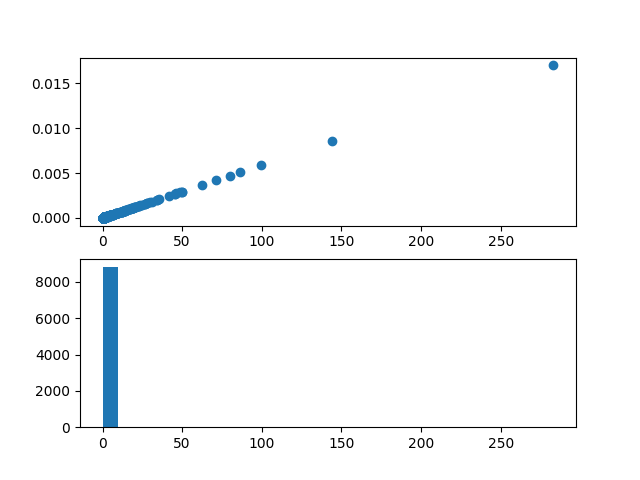

In [6]:
fig, axs = plt.subplots(2,1)
axs[0].scatter(dfs["tradesize_token1"], dfs["slippage"])
axs[1].hist(dfs["tradesize_token1"], bins=30)
plt.show()

8884


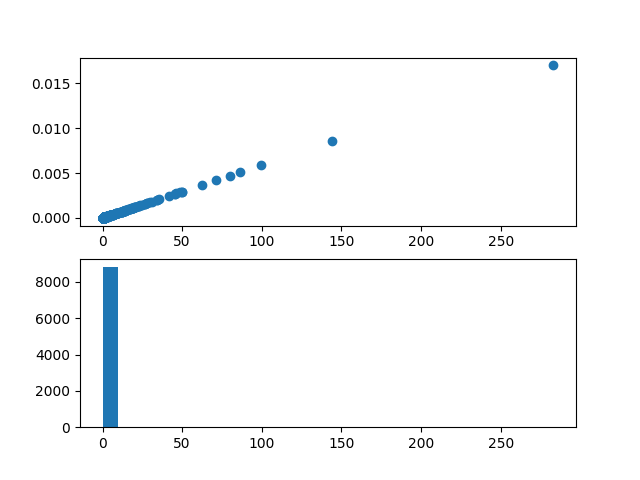

In [7]:
df = dfs[dfs["slippage"] > 0.00000]
# df["target"] = df["slippage"] * df["tradesize_token1"].max() / df["slippage"].max()
df["target"] = df["slippage"]
print(len(df))

fig, axs = plt.subplots(2,1)
axs[0].scatter(df["tradesize_token1"], df["target"])
axs[1].hist(df["tradesize_token1"], bins=30)
plt.show()

In [8]:
# Fitting

from sklearn.model_selection import KFold
import numpy as np


In [9]:
for col in ["tradesize_token0", "tradesize_token1", "target"]:
    df[col] = df[col].astype(float)

In [10]:
k = 10
kf = KFold(n_splits=k, shuffle=True)

degrees = [1, 2, 3, 4]

X = df["tradesize_token1"].values
t = df["target"].values

test_mse = []

for train_index, test_index in kf.split(X, t):
    split_mse = []
    for deg in degrees:
        
        w = np.polyfit(X[train_index], t[train_index], deg)
        y = np.polyval(w, X[test_index])
        
        mse = np.mean((t[test_index] - y)**2)
        split_mse.append(mse)
    
    test_mse.append(split_mse)

mean_mse = np.mean(test_mse, axis=0)
best_degree = degrees[mean_mse.argmin()]
print(f"Best degree: {best_degree}")
        

Best degree: 3


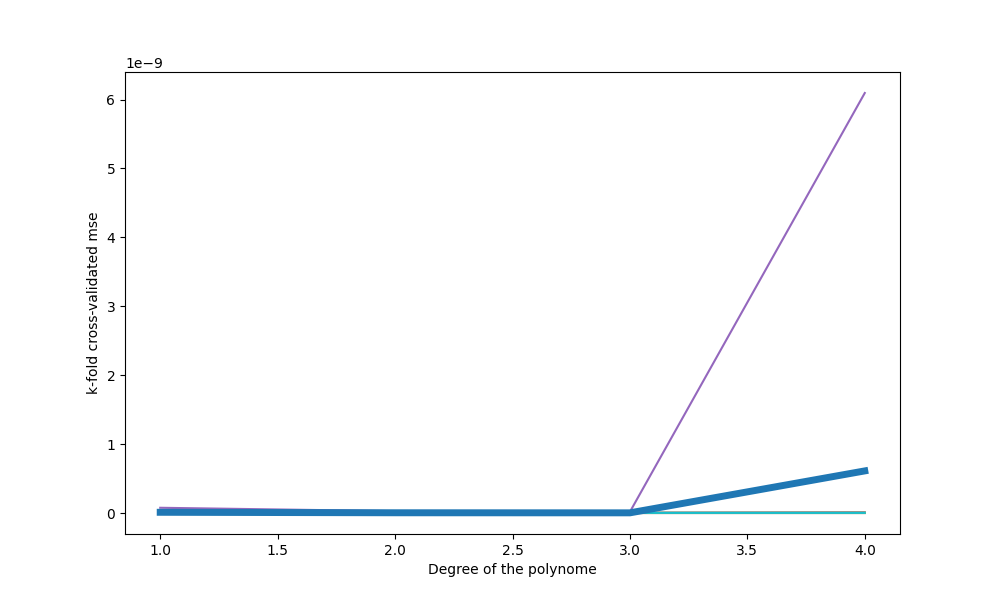

In [11]:
plt.figure(figsize=(10, 6))
for mse in test_mse:
    plt.plot(degrees, mse)
plt.plot(degrees, mean_mse, lw=5)
plt.xlabel("Degree of the polynome")
plt.ylabel("k-fold cross-validated mse")
plt.show()

deg: 1 	 coefficients: [-2.58209703e-07  5.96579784e-05]
deg: 2 	 coefficients: [1.00231978e-07 5.89525231e-05 4.12773540e-09]
deg: 3 	 coefficients: [ 1.35758050e-08  5.91622619e-05 -4.21275868e-10  1.37964171e-11]
deg: 4 	 coefficients: [2.26563590e-08 5.91367364e-05 7.78232660e-10 2.11818621e-12
 2.74301393e-14]


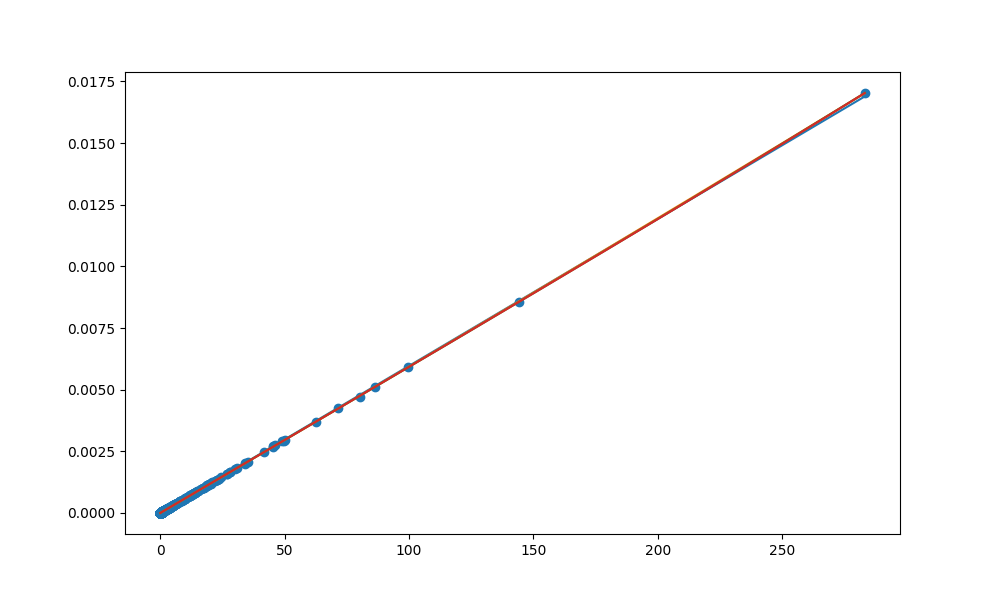

In [12]:
X_range = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(10, 6))

for deg in degrees:
    w = np.polyfit(X, t, deg=deg)  # w is sorted highest power first
    y_hat = np.polyval(w, X_range)


    plt.plot(X_range, y_hat)

    print(f"deg: {deg} \t coefficients: {w[::-1]}")  

plt.scatter(X, t)
plt.show()


Even though degree 2+ give better fits, but higher degrees dont contribute much compared to deg=1 (see coefficients)

So maybe better choose deg=1 model anyways for better explainability?